Notebook for how to load the object detection data from the NORD-FKB project.

In [1]:
import os
import json
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2 as cv
import numpy as np

In [2]:
data_dir = "20250507_NORD_FKB_Som_Korrigert"
ann_file = os.path.join(data_dir, "coco_dataset.json")

coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [8]:
import matplotlib.patches as patches
import random

def display_image_with_random_colored_bboxes(coco, img_id):
    # Load image
    img_info = coco.loadImgs(img_id)[0]
    img_path = os.path.join(data_dir, img_info['file_name'])
    image = cv.imread(img_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Load annotations
    ann_ids = coco.getAnnIds(imgIds=img_info['id'])
    anns = coco.loadAnns(ann_ids)

    # Display image
    plt.imshow(image)
    ax = plt.gca()

    # Iterate over each annotation to draw the bounding box
    for ann in anns:
        bbox = ann['bbox']
        category_name = coco.loadCats(ann['category_id'])[0]['name']
        
        # Generate a random color
        color = [random.random() for _ in range(3)]
        
        # Create a rectangle patch with a random color
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor=color, facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        # Add category name as text with the same color
        plt.text(bbox[0], bbox[1] - 10, category_name, color=color, fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

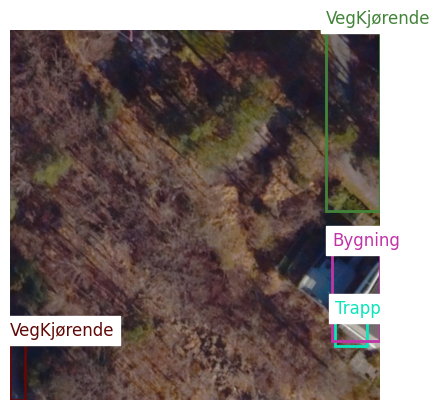

In [12]:
# Get a random image id
img_ids = coco.getImgIds()
img_id = img_ids[np.random.randint(0, len(img_ids))]

# Display the image with annotations
display_image_with_random_colored_bboxes(coco, img_id)

In [13]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [16]:
class COCOObjectDetectionDataset(Dataset):
    def __init__(self, data_dir, ann_file, transform=None):
        self.data_dir = data_dir
        self.coco = COCO(ann_file)
        self.img_ids = self.coco.getImgIds()
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.data_dir, img_info['file_name'])
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        # Extract bounding boxes and labels
        bboxes = []
        labels = []
        for ann in anns:
            bbox = ann['bbox']
            # Convert bbox from [x, y, width, height] to [x_min, y_min, x_max, y_max]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            bboxes.append(bbox)
            labels.append(ann['category_id'])

        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, {'boxes': bboxes, 'labels': labels}

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create dataset and dataloader
data_dir = '20250507_NORD_FKB_Som_Korrigert'
ann_file = os.path.join(data_dir, 'coco_dataset.json')
dataset = COCOObjectDetectionDataset(data_dir, ann_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [28]:
def unnormalize_image(tensor, mean, std):
    """
    Un-normalize a tensor image to its original form.
    """
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_image_with_bboxes(image_tensor, bboxes_and_labels=None):
    """
    Visualize a single image tensor with optional bounding boxes.
    """

    if bboxes_and_labels is not None:
        bboxes = bboxes_and_labels["boxes"]
        labels = bboxes_and_labels["labels"]
    else:
        bboxes = None
        labels = None

    # Un-normalize the image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = unnormalize_image(image_tensor.clone(), mean, std)
    
    # Convert to numpy and transpose to (H, W, C)
    image = image.permute(1, 2, 0).cpu().numpy()
    
    # Clip values to [0, 1] range for display
    image = np.clip(image, 0, 1)
    
    plt.imshow(image)
    ax = plt.gca()

    if bboxes is not None:
        # Iterate over each bounding box
        for i, bbox in enumerate(bboxes):
            # Generate a random color
            color = [random.random() for _ in range(3)]
            
            # Create a rectangle patch with a random color
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor=color, facecolor='none')
            
            # Add the rectangle to the plot
            ax.add_patch(rect)
            
            # Add category name as text with the same color
            if labels is not None:
                plt.text(bbox[0], bbox[1] - 10, str(labels[i].item()), color=color, fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

torch.Size([3, 512, 512]) tensor(-1.9832) tensor(1.8731)
unique labels: tensor([231, 233, 235, 236, 246])
num labels: 11


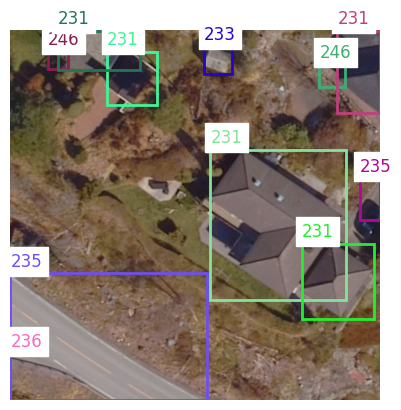

torch.Size([3, 512, 512]) tensor(-1.9809) tensor(2.2566)
unique labels: tensor([231, 235, 246])
num labels: 5


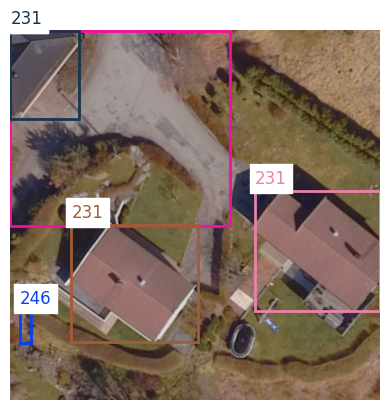

torch.Size([3, 512, 512]) tensor(-1.8957) tensor(2.0648)
unique labels: tensor([231])
num labels: 3


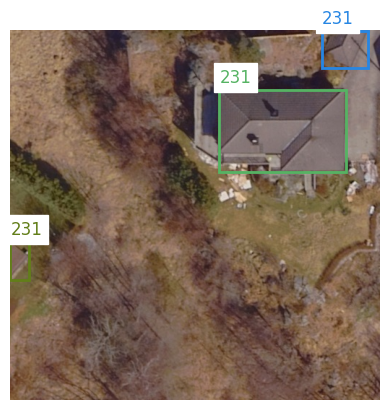

torch.Size([3, 512, 512]) tensor(-1.9657) tensor(2.0997)
unique labels: tensor([231, 236])
num labels: 2


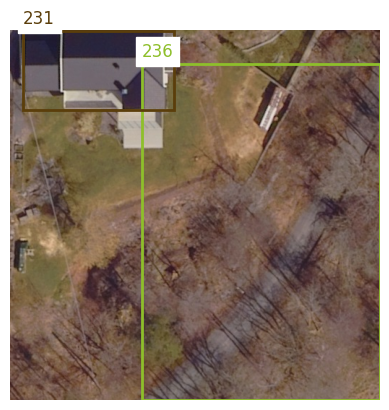

torch.Size([3, 512, 512]) tensor(-1.7522) tensor(1.5639)
unique labels: tensor([236, 250])
num labels: 2


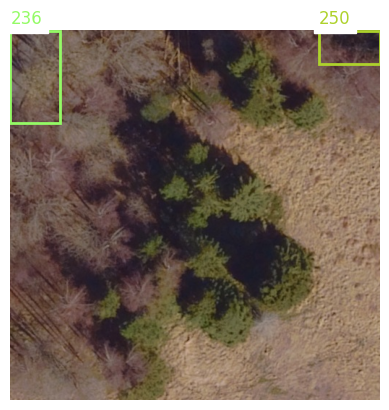

In [29]:
for i in range(5):
    image, bboxes = dataset[i]
    print(image.shape, image.min(), image.max())
    print("unique labels:", bboxes["labels"].unique())
    print("num labels:", len(bboxes["boxes"]))
    visualize_image_with_bboxes(image, bboxes)